<a href="https://colab.research.google.com/github/evanstos/plataformas_cognitivas/blob/desenvolvimento/Plataformas_Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

Imports de Pacotes

In [ ]:
!pip install --upgrade "ibm-watson>=4.0.1"
!pip install --upgrade "azureml-core==1.0.83"
!pip install --upgrade "azureml-dataprep==1.1.35"
!pip install --upgrade "azure-cognitiveservices-vision-face==0.4.0"

In [5]:
from IPython.display import display, Javascript
from IPython.display import Image
from google.colab.output import eval_js
from base64 import b64decode
from ibm_watson import VisualRecognitionV3
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from PIL import Image as ImgPIL, ImageDraw
import json
import requests

Declaracao de variaveis

In [13]:
#Nome da Imagem
filename = "fotos/foto_cliente.jpg"
urlModelGoogle = "http://35.202.255.46:8080/modelo_credito"

In [14]:
#https://cloud.ibm.com/
#Serviço: VisualRecognitionV3
#Get authenticator in Service credentials
authenticator = IAMAuthenticator('7JLj77cJlAoFi0185S8vy9cp8pcsiCmrEZqVFSbLtDKR')

In [15]:
#dont change version
visual_recognition = VisualRecognitionV3(
    version='2018-03-19',
    authenticator=authenticator
)

In [16]:
visual_recognition.set_service_url("https://api.us-south.visual-recognition.watson.cloud.ibm.com/instances/e606bf88-2faf-4bd4-9425-90c9f02b16b8")

In [ ]:
#Classificar Imagem em um Link
#url = 'https://ibm.biz/BdzLPG'
#classes_result = visual_recognition.classify(url=url).get_result()
#print(json.dumps(classes_result, indent=2))

In [ ]:
#Classificar imagem em um arquivo no local
#with open('terno.jpg', 'rb') as images_file:
#  classes_result = visual_recognition.classify(images_file=images_file).get_result()
#  print(json.dumps(classes_result, indent=2))

Função do google para capturar foto da webcam

In [6]:
def take_photo(filename, quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# Informações do cliente

In [7]:
#@title Preencha aqui com as informações do cliente requisitante

#@markdown Informe todos os campos a seguir:
nome = "Evandro dos Santos Oliveira" #@param {type:"string"}

renda =  6000#@param {type:"number"}
idade = 29 #@param {type:"slider", min:18, max:100, step:1}
etnia = "Etnia01"  #@param ["Selecionar etnia", "Etnia01", "Etnia02"]
genero = "Masculino" #@param ["Masculino", "Feminino"]
casa_propria = "Sim" #@param ["Selecionar", "Sim", "Nao"]
outras_rendas = "Nao" #@param ["Selecionar", "Sim", "Nao"]
estado_civil = "Estado01" #@param ["Selecionar", "Estado01", "Estado02"]
escolaridade = 3 #@param {type:"slider", min:0, max:3, step:1}

#@markdown ---


<IPython.core.display.Javascript object>

Saved to fotos/foto_cliente.jpg


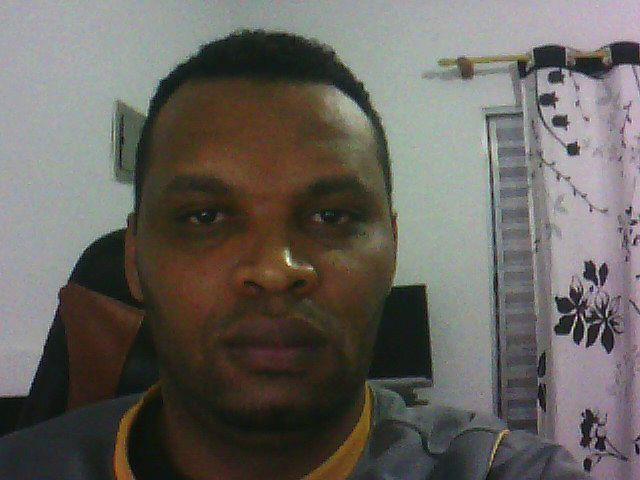

In [10]:
#@title Tire uma foto do cliente requerente (ou tire uma foto sua mesmo)

try:
  take_photo(filename)
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# Análise de crédito

1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.


2.  Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.  


3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos), informar mensagem e não conceder o empréstimo.


4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure. (em uma aplicação corporativa, estes pontos ficam gravados para futuras autenticações)


5. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud. Esta API deve usar os dados informados neste notebook e **automaticamente** vetar ou conceder o empréstimo.


ATENÇÃO PARA O BULLET 5: É necessário chamar tanto um modelo que possua a variável ETNIA quanto um modelo que não possui esta variável, assim como fizemos em aula!!!


6. Gravar um vídeo "operando" o notebook e simulando a avaliação com concessão ou reprovação do crédito.


7. Submeter o Notebook e o vídeo da plataforma da FIAP, se o vídeo ficar muito grande, submeter ao Youtube (pode ser privado) e anexar o Link.

---  
(Dica: Você pode usar este vídeo para divulgar seu trabalho como Engenheiro de ML)


In [11]:
def analysePicture(visual_recognition,urlPicture,threshold=0.7,classifier_ids="default"):
  '''
    Description:
      Função de Analise de Imagem utilizando a API Visual Recognition da IBM
      Verifica se a foto é de uma pessoa e se não possui conteúdo explícito

    Parameters:
      visual_recognition
        Objeto VisualRecognitionV3 já instânciado
      urlPicture
        URL da Imagem
      threshold
        Percentural de acurácia que a analise deve atingir para que a função tenha 
        um retorno positivo
      classifier_ids - API utilizada (default ou explicit) 
      
  '''

  foundClass = False

  if classifier_ids == "explicit":
    class_picture = "explicit"
  else: 
    class_picture = "person"

  with open(urlPicture, 'rb') as images_file:
    classes_result = visual_recognition.classify(images_file=images_file,threshold=threshold,classifier_ids=classifier_ids).get_result()

  classes = classes_result['images'][0]['classifiers'][0]['classes']
  
  for classe in classes:
    if classe.get("class") == class_picture:
      foundClass = True
      exit

  return foundClass

# 1. Verifique se na imagem possui uma pessoa, utilizando a API "default" da IBM; Se não possuir, informar mensagem e não conceder o empréstimo.

# 2. Verifique se a imagem apresenta conteúdo explícito , utilizando a API "explicit"da IBM; Se possuir, informar mensagem e não conceder o empréstimo.

In [19]:
#Teste da Função analysePicture
lPictureOK = False

#Analisa se a foto é de uma pessoa
if analysePicture(visual_recognition,filename,0.65):
  #Analisa se a foto possui conteudo explicito
  if not (analysePicture(visual_recognition,filename,0.75,"explicit")):
    lPictureOK = True
  
if lPictureOK:
  print("Pessoa Identificada. Foto Aprovada")
else:
  print("Não foi possível Identificar uma pessoa nesta foto. Try Again")

Pessoa Identificada. Foto Aprovada


# **Verificação de Gênero e Idade (AZURE)**


In [21]:
#Cria o Client da API
if __name__ == "__main__":
    #Cria o Client da API
    with open("./azurekeys.json", 'r') as jsonfile:
        azurekeys = json.load(jsonfile)

    KEY = azurekeys["FacialDetection"]["KEY"] 
    ENDPOINT = azurekeys["FacialDetection"]["ENDPOINT"]  
    face_client = FaceClient(ENDPOINT, CognitiveServicesCredentials(KEY))

    return_face_attributes = ["age", "gender", "headPose", "smile", "hair", "accessories", "facialHair", "glasses", "emotion",  "noise", "occlusion", "blur", "makeup"]
    with open(filename, 'r+b') as w:
        detected_faces = face_client.face.detect_with_stream(image=w, return_face_landmarks = True, return_face_attributes = return_face_attributes)
        
    pass

In [22]:
print(detected_faces)

In [23]:
def drawCrossesOnFace(faceLandmarks, size=2, color='white'):
    fl = faceLandmarks.as_dict()
    for l in fl.keys():
        x = fl[l]['x']
        y = fl[l]['y']
        draw.line(((x - size, y - size), (x + size, y + size)), fill=color)
        draw.line(((x - size, y + size), (x + size, y - size)), fill=color)
    pass
    return fl

In [36]:
for face in detected_faces:
  land = face.face_landmarks
  att =  face.face_attributes

# 3. Verificar o gênero e a idade da pessoa utilizando a API de reconhecimento facial da Microsoft Azure; Se não for o mesmo gênero ou se a idade diferir em 5 anos (para mais ou para menos , informar mensagem e não conceder o empréstimo

In [38]:
idade_modelo = att.as_dict()['age']

if idade <= (idade_modelo + 5)  and idade >= (idade_modelo - 5): 
  print("Idade da Imagem condiz com o cadastro - ok")
else:
  print("Idade da imagem não condiz com o cadastro - recusar")

Idade da Imagem condiz com o cadastro - ok


# 4. Exibir a imagem novamente no notebook com os pontos "fiduciais" da face da pessoa, obtidos pela API da Azure.

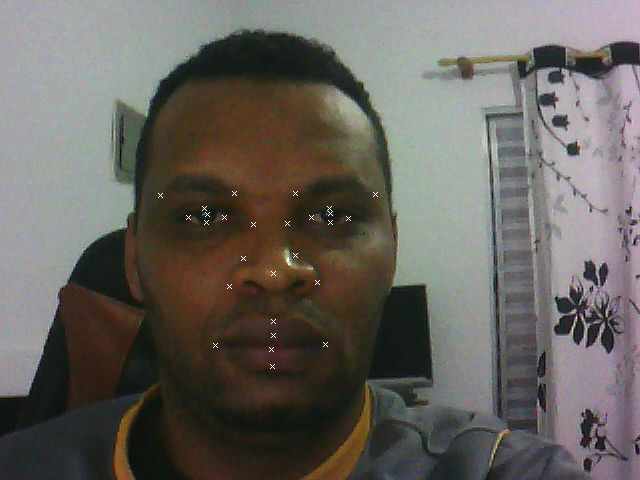

In [39]:
img = ImgPIL.open(filename)
draw = ImageDraw.Draw(img)

drawCrossesOnFace(land, size=2, color='white')
display(img)


# 5. Treinar um modelo na tecnologia e framework que preferir para ser consumido pelo próximo item

# 6. Chamar a API de Machine Learning em um contêiner feito em Docker e que esteja rodando em uma máquina virtual no Google Cloud

In [40]:
#criando body
chave = {}
chave['renda'] = {"1" : renda}
chave['idade'] = {"1" : idade}
chave['etnia'] = {"1" : 1 if etnia == "Etnia01" else 2}
chave['outras_rendas'] = {"1" : 1 if outras_rendas == "Sim" else 2 } 
chave['sexo'] = {"1" : 1 if genero == "Masculino" else 2} 
chave['casapropria'] = {"1" : 1 if casa_propria == "Sim" else 2 }
chave['estadocivil'] = {"1" : 1 if estado_civil == "Estado01" else 2}
chave['escolaridade'] = {"1" : escolaridade}
chave['default'] = {"1" : 0}

body = json.dumps(chave, indent=0)

In [41]:
headers = {'Content-Type': 'application/json'}
response = requests.request("POST", urlModelGoogle, headers=headers, data=body)
aprovacao = json.loads(response.text.encode('utf8').decode())

In [42]:
print('credito aprovado' if aprovacao['prediction'][0] == 0 else 'credito rejeitado')

credito aprovado
